## import libraries

In [1]:
import cv2, sys, os, random, json, math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from sklearn.svm import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import classification_report
from stitching.stitch import *

## read in training/testing data

In [2]:
%cd '/home/uzumochi/eigenjuno/data/train/contrast'

## TRY BOOTSTRAP?

# read in contrasted data and tags
tags = genfromtxt('/home/uzumochi/eigenjuno/data/train/tags.csv', delimiter=',')[:350]
vec_size = 256 * 256 * 3;
data = np.empty((350, vec_size))

for t in range(350):
    img = mpimg.imread(str(t + 1) + '.png')
    data[t, :] = np.reshape(img[:, :, :3], vec_size)

# # ensure dataset class distribution is even
# storm_indices = []
# no_storm_indices = []

# for t in range(350):
#     if tags[t] == 1:
#         storm_indices.append(t)
#     else:
#         no_storm_indices.append(t)

# number_zeros = int(len(no_storm_indices) / 2)

# selected_indices = np.append(random.sample(storm_indices, number_zeros), no_storm_indices)

# selected_tags = []

# selected_imgs = np.empty((len(selected_indices), vec_size))

# curr = 0
# for i in selected_indices:
#     img = mpimg.imread(str(i + 1) + '.png')
#     img = img[:, :, :3]
#     img_1d = np.reshape(img, vec_size)
#     selected_imgs[curr, :] = img_1d;
#     selected_tags = np.append(selected_tags, tags[i])
#     curr += 1
    
# tags = np.append(selected_tags, np.full(10, -1)) # int(number_zeros / 4)
# data = np.append(selected_imgs, np.full((10, vec_size), 0), axis = 0)

# tags = selected_tags
# data = selected_imgs

# set loop parameters
# iterations = 1
# test_size = 40

/home/uzumochi/eigenjuno/data/train/contrast


## display contrasted dataset

In [ ]:
fig, axes = plt.subplots(int(data.shape[0] / 11), 11, figsize = (15, 100));
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i, :].reshape(256, 256, 3))
    ax.title.set_text(str(int(tags[i])))
    ax.axis('off')
plt.show()

## perform training w/ pca and eigenimaging

In [8]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, tags, test_size = 0.2)

# perform pca transform
pca_X = PCA(n_components = 0.9, svd_solver = 'full').fit(X_train)
print('Decomposed test set to', pca_X.components_.shape[0], 'components')
# eigenfaces = pca_X.components_.reshape((X_train.shape[0], 256, 256, 3))
X_train = pca_X.transform(X_train)

# apply pca transform to x_test
X_test = pca_X.transform(X_test)

# fit classifier to data
C_RANGE = np.logspace(-3, 3, 20)
G_RANGE = np.logspace(-9, 1, 20)
param_grid = { 'C': C_RANGE,
#                'gamma': G_RANGE,
               'gamma': ['scale', 'auto'],
               'degree': [1, 2, 3, 4],
               'kernel': ['poly', 'rbf'],
               'class_weight': ['balanced'],
               'coef0': [0, 1] }

grid = GridSearchCV(SVC(), param_grid, n_jobs = -1, verbose = 1)
grid.fit(X_train, y_train)
print('Optimal parameter values:')
print('C:', grid.best_params_['C'])
print('kernel:', grid.best_params_['kernel'])
print('gamma:', grid.best_params_['gamma'])
print('degree:', grid.best_params_['degree'])
print('coef0:', grid.best_params_['coef0'])

# generate report
print('Calculating metrics...')
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
scores = cross_val_score(grid, X_test, y_test, cv = 6)
print(scores)

Decomposed test set to 36 components
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Optimal parameter values:
C: 12.742749857031322
kernel: rbf
gamma: scale
degree: 1
coef0: 0
Calculating metrics...
              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83        30
         1.0       0.86      0.90      0.88        40

    accuracy                           0.86        70
   macro avg       0.86      0.85      0.85        70
weighted avg       0.86      0.86      0.86        70

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
[0.83333333 0.83333333 0.83333333 0.91666667 0.90909091 0.81818182]


## print results and analysis

In [ ]:
print(classification_report(y_test, y_pred_SVC))
print(classification_report(y_test, y_pred_MLP))
print(classification_report(y_test, y_pred_NN))
print(classification_report(y_test, y_pred_NUS))

## plot eigenfaces

In [ ]:
eigenfaces = (abs(eigenfaces.astype('float32'))).astype('uint8')
fig, axes = plt.subplots(4, 6, figsize = (15, 10));
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i, :]);
    ax.axis('off')
plt.show()

## visualize results w/ images

In [ ]:
fig, axes = plt.subplots(6, 6, figsize = (15, 20));
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i - 1, :].reshape(256, 256, 3))
    ax.title.set_text('val: ' + str(int(y_test[i - 1])) + " / pred: " + str(int(y_pred_SVC[i - 1])))
    ax.axis('off')
plt.show()

## contrast single test image

In [ ]:
name = 'test2'
img = cv2.imread('/home/uzumochi/eigenjuno/data/test/' + name + '.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB);
l, a, b = cv2.split(img);
clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8, 8));
img_l = clahe.apply(l);
img_l = cv2.merge((img_l, a, b));
final = cv2.cvtColor(img_l, cv2.COLOR_LAB2BGR);
final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB);
img = cv2.resize(final, (2048, 2048), interpolation = cv2.INTER_NEAREST)
plt.imsave('/home/uzumochi/eigenjuno/data/test/' + name + '_contrast.png', img)

## divide-and-conquer pipeline for testing full images

In [ ]:
%cd '/home/uzumochi/eigenjuno/data/test'

# chop up image
test_name = 'test2_contrast'
vec_size = 256 * 256 * 3
img = cv2.imread(test_name + '.png', 3)
b, g, r = cv2.split(img)
img = cv2.merge((r, g, b))
img = (img / 255)
split_img_4 = np.empty((4, vec_size))
split_img_16 = np.empty((16, vec_size))
split_img_64 = np.empty((64, vec_size))
split_img_256 = np.empty((256, vec_size))

In [ ]:
############### 128X128 RESOLUTION BLOCKS ################
start_row, end_row, start_col, end_col = 0, 128, 0, 128
non_zero_blocks = []
index = 0
for i in range(256):
    block = img[start_row : end_row, start_col : end_col]
    if end_col != 2048:
        start_col += 128
        end_col += 128
    else:
        start_col, end_col = 0, 128
        start_row += 128
        end_row += 128
    block = cv2.resize(block, (256, 256), interpolation = cv2.INTER_NEAREST)
    block = np.reshape(block, vec_size)
    split_img_256[i, :] = block
    zero_locs = np.where(block < 0.025)[0]
    if zero_locs.size == 0:
        index += 1
        non_zero_blocks = np.append(non_zero_blocks, i)

# generate predictions for individual blocks
testing_blocks = split_img_256[non_zero_blocks.astype(int), :]
transform_test_256 = pca_X.transform(testing_blocks)
split_pred_256 = grid.predict(transform_test_256)

# graph results
fig, axes = plt.subplots(16, 16, figsize = (18, 24));
index = 0
for i, ax in enumerate(axes.flat):
    ax.imshow(split_img_256[i, :].reshape(256, 256, 3))
    if i in non_zero_blocks:
        ax.title.set_text(str(float(split_pred_256[index])))
        index += 1
    ax.axis('off')

In [ ]:
############### 256X256 RESOLUTION BLOCKS ################
start_row, end_row, start_col, end_col = 0, 256, 0, 256
non_zero_blocks = []
index = 0
for i in range(64):
    block = img[start_row : end_row, start_col : end_col]
    if end_col != 2048:
        start_col += 256
        end_col += 256
    else:
        start_col, end_col = 0, 256
        start_row += 256
        end_row += 256
    block = np.reshape(block, vec_size)
    split_img_64[i, :] = block
    zero_locs = np.where(block < 0.025)[0]
    if zero_locs.size == 0:
        index += 1
        non_zero_blocks = np.append(non_zero_blocks, i)

# generate predictions for individual blocks
testing_blocks = split_img_64[non_zero_blocks.astype(int), :]
transform_test_64 = pca_X.transform(testing_blocks)
split_pred_64 = grid.predict(transform_test_64)

# graph results
fig, axes = plt.subplots(8, 8, figsize = (18, 18));
index = 0
for i, ax in enumerate(axes.flat):
    ax.imshow(split_img_64[i, :].reshape(256, 256, 3))
    if i in non_zero_blocks:
        ax.title.set_text(str(float(split_pred_64[index])))
        index += 1
    ax.axis('off')

In [ ]:
############### 512X512 RESOLUTION BLOCKS ################
start_row, end_row, start_col, end_col = 0, 512, 0, 512
non_zero_blocks = []
index = 0
for i in range(16):
    block = img[start_row : end_row, start_col : end_col]
    if end_col != 2048:
        start_col += 512
        end_col += 512
    else:
        start_col, end_col = 0, 512
        start_row += 512
        end_row += 512
    block = cv2.resize(block, (256, 256))
    block = np.reshape(block, vec_size)
    split_img_16[i, :] = block
    zero_locs = np.where(block < 0.025)[0]
    if zero_locs.size == 0:
        index += 1
        non_zero_blocks = np.append(non_zero_blocks, i)

# generate predictions for individual blocks
testing_blocks = split_img_16[non_zero_blocks.astype(int), :]
transform_test_16 = pca_X.transform(testing_blocks)
split_pred_16 = grid.predict(transform_test_16)

# graph results
fig, axes = plt.subplots(4, 4, figsize = (18, 18));
index = 0
for i, ax in enumerate(axes.flat):
    ax.imshow(split_img_16[i, :].reshape(256, 256, 3))
    if i in non_zero_blocks:
        ax.title.set_text(str(float(split_pred_16[index])))
        index += 1
    ax.axis('off')    

In [ ]:
############### 1024X1024 RESOLUTION BLOCKS ################
start_row, end_row, start_col, end_col = 0, 1024, 0, 1024
non_zero_blocks = []
index = 0
for i in range(4):
    block = img[start_row : end_row, start_col : end_col]
    if end_col != 2048:
        start_col += 1024
        end_col += 1024
    else:
        start_col, end_col = 0, 1024
        start_row += 1024
        end_row += 1024
    block = cv2.resize(block, (256, 256))
    block = np.reshape(block, vec_size)
    split_img_4[i, :] = block
    zero_locs = np.where(block < 0.025)[0]
    if zero_locs.size == 0:
        index += 1
        non_zero_blocks = np.append(non_zero_blocks, i)

if len(non_zero_blocks) != 0:
    # generate predictions for individual blocks
    testing_blocks = split_img_4[non_zero_blocks.astype(int), :]
    transform_test_4 = pca_X.transform(testing_blocks)
    split_pred_4 = grid.predict(transform_test_4)

    # graph results
    fig, axes = plt.subplots(2, 2, figsize = (18, 18));
    index = 0
    for i, ax in enumerate(axes.flat):
        ax.imshow(split_img_4[i, :].reshape(256, 256, 3))
        if i in non_zero_blocks:
            ax.title.set_text(str(float(split_pred_4[index])))
            index += 1
        ax.axis('off')

In [ ]:
# need to consolidate detections across resolutions

## contrast images, resize to 256x256, and save

In [ ]:
%cd '/home/uzumochi/eigenjuno/data/train/cropped'
for i in range(281, 376):
    img = cv2.imread(str(i) + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB);
    l, a, b = cv2.split(img);
    clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8, 8));
    img_l = clahe.apply(l);
    img_l = cv2.merge((img_l, a, b));
    final = cv2.cvtColor(img_l, cv2.COLOR_LAB2BGR);
    final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB);
    img = cv2.resize(final, (256, 256), interpolation = cv2.INTER_NEAREST)
    plt.imsave('/home/uzumochi/eigenjuno/data/train/contrast/' + str(i) + '.png', img)

## pca with uncontrasted data - minimum components

In [ ]:
pca = PCA(n_components = 6).fit(data)
plt.figure(figsize = (15, 5));
plt.plot(pca.explained_variance_ratio_.cumsum());
plt.xlabel('Number of Principal Components');
plt.ylabel('Explained Variance Ratio');
plt.title('Explained Variance Ratio of Principal Components in a Contrasted Dataset: First 5 Components');

## pca with uncontrasted data - all components

In [ ]:
pca = PCA().fit(data)
plt.figure(figsize = (15, 5));
plt.plot(pca.explained_variance_ratio_.cumsum());
plt.xlabel('Number of Principal Components');
plt.ylabel('Explained Variance Ratio');
plt.title('Explained Variance Ratio of Principal Components in a Contrasted Dataset');

## useful functions for spice matrices

In [ ]:
# convert rotational matrix to euler angles
def rot_matrix_to_euler(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

# convert euler angles in radians to degrees
def radians_to_degrees(R):
    x = math.degrees(R[0])
    y = math.degrees(R[1])
    z = math.degrees(R[2])
    return np.array([x, y, z])

## read test image metadata

In [18]:
import json, math, os
import numpy as np
import spiceypy as spice

KERNELS = [ "naif0012.tls",
            "de440s.bsp",
            "juno_v12.tf",
            "jup380s.bsp",
            "jno_sclkscet.00129.tsc",
            "pck00010.tpc",
            "juno_junocam_v03.ti",
            "perijove_21.bsp",
            "perijove_21.bc" ]

KERNELDIR = os.path.expanduser("~/eigenjuno/stitching/kernels")

spice.kclear()
for k in KERNELS:
    spice.furnsh(os.path.join(KERNELDIR, k))

JUNO_JUNOCAM = -61500
JUNO_JUNOCAM_BLUE = -61501
JUNO_JUNOCAM_GREEN = -61502
JUNO_JUNOCAM_RED = -61503

EQUATORIAL_RADIUS = 71492
POLAR_RADIUS = 66854
FLATTENING = (EQUATORIAL_RADIUS - POLAR_RADIUS) / EQUATORIAL_RADIUS

with open('/home/uzumochi/eigenjuno/data/raw/perijove_21/7251-Metadata.json', 'r') as f:
    im_info_dir = json.load(f)
    image = im_info_dir['FILE_NAME']
    image_time = im_info_dir['START_TIME']
    juno_pos = [float(im_info_dir['SUB_SPACECRAFT_LONGITUDE']), 
                float(im_info_dir['SUB_SPACECRAFT_LATITUDE'])]

et = spice.str2et(image_time)
print(image_time)

2019-07-21T06:40:53.271


## find lat/long of image centerpoint

In [19]:
pos, orient = spice.spkpos('JUNO', et, 'IAU_JUPITER', 'NONE', 'JUPITER')
print([pos[0], pos[1], pos[2]])
# long, lat, altitude = spice.recpgr('JUPITER', pos, equatorial_radius, flattening)
radius, long, lat = spice.reclat(pos)
print([long, lat])

[-63901.43782252212, -40552.71208205261, -298452.8298811491]
[-2.5761101427615323, -1.3224469147336484]


In [23]:
shape, frame, bsight, n, bounds = spice.getfov(JUNO_JUNOCAM_BLUE, 4, 32, 32)
spoint, trgepc, srfvec = spice.sincpt('Ellipsoid', 'JUPITER', et, 'IAU_JUPITER', 'CN+S', 'JUNO', frame, bsight)
radius, long, lat = spice.reclat(spoint)
print([long, lat])

NotFoundError: Spice returns not found for function: sincpt

In [ ]:
spoint, trgepc, srfvec = spice.sincpt("Ellipsoid", "JUPITER", et, "IAU_JUPITER", "CN+S", "JUNO", frame, bsight)

In [10]:
cx = 814.21
cy = 78.48
k1 = -5.9624209455667325e-08
k2 = 2.7381910042256151e-14

def undistort(xd, yd):
    for i in range(5):
        r2 = (xd**2 + yd**2)
        dr = 1 + k1 * r2 + k2 * r2 * r2
        xd = xd / dr
        yd = yd / dr
    return [xd, yd]

surf_raster = np.loadtxt('/home/uzumochi/eigenjuno/data/raw/perijove_9/3100_surf_raster.txt')
surf_raster = np.reshape(surf_raster, (2048, 2048, 3))
planetocentric = np.empty((2048, 2048, 2))
for i in range(2048):
    for j in range(2048):
        _, planetocentric[i, j, 0], planetocentric[i, j, 1] = spice.reclat(surf_raster[i, j, :])

In [11]:
x = planetocentric[:, :, 0] #- cx
y = planetocentric[:, :, 1] #- cy
proj_long, proj_lat = undistort(x, y)

In [12]:
print(proj_lat[1000, 500])

-0.9355272438241019


In [ ]:
surf_raster = np.loadtxt('/home/uzumochi/eigenjuno/data/raw/perijove_9/3100_surf_mask.txt', dtype = int)
surf_raster = np.reshape(surf_raster, (2048, 2048))
mask, _ = undistort(surf_raster, surf_raster)

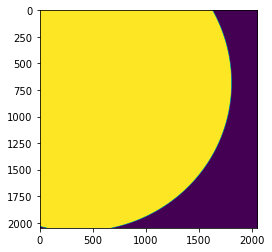

In [16]:
plt.imshow(surf_raster)

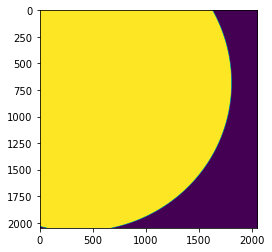

In [17]:
plt.imshow(mask)

In [ ]:
# zoom in/out to focus on desired feature


In [ ]:
# track features with centerpoint


In [ ]:
# save in log file w/ coordinates, perijove, and feature id


In [ ]:
# end of notebook